In [1]:
!pip install pyDOE

In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x,0,0.05).T

#collocation points for every position and every time
X, T = np.meshgrid(x,t)


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [3]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [4]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [5]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=1 
        sigma2=0.1

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(loss_value, loss_u, loss_f, error_vec)

# *Solution Plot*

In [146]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.05s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.075s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

0.98439352733852492 0.324082394646146 0.660311132692379 1.938228820948587
0.37458236879277546 0.32858012094674183 0.046002247846033642 2.1433990343313405
0.36553920865370443 0.32871453654992178 0.036824672103782666 2.0738038553008074
0.36091477444923858 0.32835508619442821 0.0325596882548104 1.9340645233767582
0.34522621937930115 0.32839986811803296 0.016826351261268205 1.292007465271852
0.33644395875860794 0.33090154127186239 0.0055424174867455744 1.0164803969121219
0.33396437549998109 0.33170632088673391 0.0022580546132471855 1.009886890099617
0.33348132629698829 0.33142225364352323 0.0020590726534650623 1.0131753321531582
0.33292799806281531 0.33075598475349616 0.0021720133093191311 1.0272855830260021
0.33184846155456788 0.32950052368864957 0.0023479378659183037 1.1125774567992162
0.33059107436627566 0.328629726021884 0.0019613483443916527 1.3136487467237292
0.32973889596273392 0.32852424753183374 0.0012146484309001968 1.4676541943074743
0.32953220759337987 0.32854570613593614 0.000

0.29715933546677609 0.28756440494062363 0.009594930526152479 8.11348086361315
0.295360645493353 0.28496129840661677 0.010399347086736207 8.721390000755834
0.29443184922305987 0.283976072926936 0.010455776296123891 9.488271723908603
0.29286273468009066 0.28187632395919593 0.01098641072089474 9.699135544810595
0.29098771734772427 0.27958269440740208 0.011405022940322198 10.138021679409563
0.2890538065706203 0.27694138650588934 0.012112420064730976 10.856610383343877
0.28791590961676417 0.27465233183070437 0.01326357778605982 11.11012397585764
0.28734276169916606 0.27348335840375593 0.013859403295410121 11.683760089227226
0.287208613626022 0.27413924840649206 0.013069365219529954 11.343187777022727
0.28687590743812807 0.27386608679948815 0.013009820638639941 11.412418843831611
0.286620352645476 0.27373578434981927 0.0128845682956567 11.371298212405936
0.28607096334926313 0.273782651410828 0.012288311938435083 11.311159801610055
0.28519849927300345 0.27492070254706991 0.010277796725933565 

0.1731405242380262 0.16008996889524832 0.013050555342777888 19.163740437076548
0.17252341046406044 0.15897741348322966 0.013545996980830788 19.06165794233934
0.17172310554226489 0.15734946189542889 0.014373643646835996 19.019354298196536
0.17054675968570371 0.15495673383737832 0.015590025848325398 19.09979534563431
0.16851827147969678 0.1507037273509266 0.017814544128770177 19.32668366902936
0.16584237153657713 0.14522911320088588 0.020613258335691258 19.59363646181671
0.16328939429944359 0.14013398525679865 0.023155409042644921 19.974346791874265
0.16086301440418735 0.13649156344160532 0.024371450962582034 20.45687053818178
0.15938585523904325 0.1338386730166615 0.02554718222238174 20.508297509782864
0.15827407661275511 0.13200294810695962 0.026271128505795494 20.55776685672187
0.15734178537577162 0.1319964454425219 0.025345339933249729 20.61048411175402
0.15710448465922605 0.13104935545371979 0.026055129205506247 20.195581741381453
0.15635993669330356 0.13287242152823156 0.0234875151

0.08209979906892402 0.071669261374087287 0.010430537694836739 22.80071405841874
0.081527489485778343 0.0709755348283563 0.010551954657422057 23.016555240219503
0.081055228259098555 0.0705962360561082 0.010458992202990359 23.266790595145235
0.080046509550969591 0.069764216625391437 0.010282292925578154 23.254354699719418
0.079173777201824419 0.068879084205204555 0.010294692996619866 23.306149653208095
0.07896153640953224 0.068683638060425087 0.010277898349107157 23.17814667295492
0.078830670549964121 0.068770214414357586 0.010060456135606528 23.162648583554166
0.078748028934098657 0.068469075324417081 0.01027895360968158 23.214198259069107
0.078666626983242616 0.06830962623587121 0.010357000747371402 23.22867834043149
0.07850585536016691 0.067708883639451822 0.010796971720715089 23.286558413836218
0.078222776278525669 0.067216240950184525 0.011006535328341144 23.228971964942367
0.0778030205325969 0.0663826908266658 0.011420329705931102 23.141894916638005
0.077126749415060036 0.065897637

0.054940640527308252 0.042801400583270754 0.012139239944037497 23.859419825808306
0.054655793527512923 0.043119476314109971 0.011536317213402951 23.850804993790327
0.054343270430729534 0.043226855282896944 0.011116415147832594 23.80820666448222
0.054123862034087269 0.043593116377620381 0.010530745656466891 23.901877446605905
0.053913853409349968 0.043616373592390775 0.01029747981695919 23.827287915024613
0.053848409777747186 0.043781222241776663 0.010067187535970521 23.798336887452134
0.053694141210792579 0.043787406840759754 0.00990673437003282 23.78663670679153
0.053597710506345167 0.0436275666993609 0.0099701438069842684 23.893426327085674
0.053481351973955149 0.043738324619669082 0.00974302735428607 23.896024126685333
0.053334104139214786 0.043789641650589281 0.009544462488625503 23.96313305468447
0.053257922612369731 0.043802037271964821 0.00945588534040491 23.994589565253477
0.053195618998245292 0.043802700983997 0.0093929180142482867 24.03907727729359
0.053092188630222033 0.0437

0.034274136021181553 0.022138594656013661 0.012135541365167889 23.80279110635789
0.033993228689406317 0.022350644309392213 0.011642584380014106 23.920074812191697
0.033885760134239155 0.022357304876240113 0.011528455257999044 24.00872055708906
0.03380760209783544 0.022449267098584687 0.011358334999250751 24.04767417969747
0.033758460418998111 0.022556069682983883 0.011202390736014228 24.018210020956797
0.03371092542874983 0.022725541391686293 0.010985384037063537 24.008556921537902
0.03362526084189927 0.022788637193763811 0.010836623648135457 23.972158831191642
0.033496726364893314 0.022775543257371487 0.01072118310752183 23.98990649302837
0.033368198959615632 0.022489822088026135 0.010878376871589499 24.01179615171312
0.033198939379881089 0.021777819264469377 0.011421120115411711 24.1268659969186
0.033108655405788591 0.021400649609320987 0.011708005796467602 24.11874764550975
0.03306626387078776 0.020998858003767336 0.012067405867020426 24.109106442665336
0.0330136519993187 0.02109874

0.022672556680885546 0.013654534224629162 0.0090180224562563822 24.492397573956875
0.022482018996891034 0.013325751653812485 0.0091562673430785491 24.400551917180124
0.022326158477239837 0.013483131757661674 0.008843026719578163 24.379987382285012
0.022280376000504743 0.013324533662394139 0.0089558423381106041 24.4380189109241
0.022241630127972187 0.013361902650003213 0.0088797274779689756 24.405380007008777
0.022196284172361844 0.013395574472425766 0.0088007096999360764 24.386386796128733
0.022167852646808074 0.013382620019697826 0.0087852326271102461 24.34844237223662
0.022144048819918754 0.013424706263990489 0.0087193425559282649 24.345730166419177
0.022127384773953859 0.013460933973733668 0.0086664508002201913 24.33973198794076
0.02210538682270597 0.013504753485983628 0.0086006333367223426 24.34115817459279
0.022066230920794398 0.013564614514082789 0.0085016164067116071 24.308033953354027
0.021990145235022341 0.013570261926013558 0.0084198833090087834 24.28149270090265
0.0218788949

0.016712748741070028 0.010249424051904944 0.0064633246891650838 24.49845163853842
0.016589175956001241 0.010047973750214649 0.0065412022057865921 24.504918328798404
0.016556582707112678 0.0099661061679645439 0.0065904765391481329 24.522703031608188
0.016409108441026062 0.0097497778843293019 0.00665933055669676 24.464322324987386
0.016278335796246685 0.0097435045020665256 0.00653483129418016 24.490864877995353
0.016132216627155992 0.0095687698933745076 0.0065634467337814823 24.515095083463088
0.016075988752328334 0.009482141098834088 0.0065938476534942473 24.532977434417823
0.016036217126180766 0.0093263152971434851 0.0067099018290372806 24.528921147356083
0.015904101665131825 0.0093504357895554842 0.00655366587557634 24.54377495623738
0.015847067364700203 0.0093621131463973127 0.0064849542183028916 24.549415724614022
0.015780915402281881 0.00938595585771497 0.0063949595445669111 24.554135035404034
0.015763505497292128 0.00927762596472079 0.0064858795325713385 24.514908795712508
0.01573

0.011812262521599677 0.00467278625938915 0.0071394762622105281 24.43269800958257
0.011795486890815199 0.0046783233340590537 0.0071171635567561448 24.416799247662695
0.011767690826631689 0.0046737478466827211 0.0070939429799489681 24.396409184681538
0.01171842429302827 0.00473997186127999 0.0069784524317482808 24.370098512078158
0.01166549463102011 0.0047661230160042957 0.0068993716150158148 24.34793862860291
0.011628760971623662 0.0047678715292173287 0.0068608894424063323 24.36226381186402
0.011603999874209518 0.0047645473534219983 0.00683945252078752 24.363395743311024
0.011567624802924071 0.0047650550424643981 0.0068025697604596732 24.370646157252
0.011545834196522765 0.0047659968516887245 0.0067798373448340393 24.39821259888614
0.011519816859059598 0.0047988322576241731 0.0067209846014354251 24.404055943859106
0.011497951971516054 0.0048195011477180083 0.006678450823798047 24.406878472990055
0.011475337344362294 0.0048481740566244207 0.0066271632877378736 24.412226158485034
0.011457

0.0082346594534866875 0.00458751680236143 0.0036471426511252582 24.957931875031893
0.0081724986785469654 0.00451085512763232 0.0036616435509146455 24.96907890807684
0.0081179142318013337 0.0044480334896353458 0.0036698807421659879 24.958351437253636
0.0080640941770553157 0.0044227466872490779 0.0036413474898062373 24.949687104436308
0.0079961357038826 0.0043922241974391051 0.0036039115064434935 24.919495492712347
0.00793170362122779 0.0044077298222900164 0.0035239737989377737 24.928209407424557
0.0079040336532018012 0.0043898759559222881 0.0035141576972795136 24.924251047932348
0.0078762749570560359 0.0043589384111525232 0.0035173365459035132 24.914472626586004
0.007848175652634827 0.0042775303153237939 0.0035706453373110323 24.93209697123959
0.007816755824170343 0.0042216144145063254 0.0035951414096640172 24.927890460316867
0.0077977644573173684 0.00420717334487337 0.0035905911124439987 24.89870623898842
0.0077848977365427858 0.0042037669554904119 0.0035811307810523735 24.915498906585

0.00560346616526864 0.0024042092735627055 0.0031992568917059341 24.97850954216144
0.0055950448988284027 0.0023729553739057566 0.0032220895249226457 24.961574533465352
0.005583182352776354 0.0023564567818075465 0.0032267255709688076 24.933539912604864
0.0055605970748938936 0.0023176819405148169 0.0032429151343790763 24.878098072328335
0.0055368440850319858 0.0022928763411763009 0.0032439677438556853 24.84222337487913
0.0055185869501195393 0.0022510363307796212 0.0032675506193399176 24.807310435497712
0.0054956211714544123 0.0022245578832859551 0.0032710632881684572 24.838035579994646
0.0054835828287024191 0.0022158465328617986 0.0032677362958406205 24.872931856294063
0.00547259367576792 0.0022001642453935637 0.0032724294303743571 24.916383546116577
0.0054675833862337566 0.0021830669132070976 0.0032845164730266586 24.92572990356377
0.0054616893024113759 0.0021902464023507229 0.0032714429000606526 24.921583269473444
0.0054540743152640923 0.0021748163075288934 0.0032792580077351994 24.9123

0.0041209157517307776 0.0013570857694906464 0.002763829982240131 25.014891771165086
0.0040806836668802 0.0013450131053259244 0.0027356705615542761 24.97492742471562
0.0040585872911231384 0.001295524432810062 0.0027630628583130766 24.972963909109946
0.0040361074774507063 0.0012808323663183931 0.0027552751111323136 24.957497638056257
0.0040271085590536226 0.0012691355585470561 0.0027579730005065665 24.96273979966913
0.00401796131635086 0.0012548914747030737 0.0027630698416477861 24.973527188719082
0.00401479285527392 0.0012356266561951745 0.0027791661990787453 24.975347606864485
0.0040127881339339731 0.0012167659942402536 0.0027960221396937193 24.95349191984132
0.004006735152136281 0.0012100212141108368 0.0027967139380254439 24.948902333361353
0.004004219299112325 0.0012167123090276065 0.002787506990084719 24.960741095154365
0.0040012079229505716 0.0012129793325109262 0.0027882285904396458 24.96450908154224
0.0039959102465666882 0.0011981119332406651 0.0027977983133260233 24.963331708560

0.0029419080646049716 0.0011235407935101841 0.0018183672710947872 25.008507286356522
0.0029371828453237129 0.0011314049953939712 0.0018057778499297418 25.010238566501528
0.0029326369483125463 0.001135579552452837 0.0017970573958597093 25.016018343522312
0.0029269240335837816 0.001139995773727731 0.0017869282598560504 25.02476166712342
0.0029213177310213061 0.0011422142277326651 0.001779103503288641 25.034855743900202
0.0029178509792298982 0.0011366822480972961 0.0017811687311326022 25.049056707780238
0.0029141864919239218 0.001128090850318316 0.0017860956416056056 25.05974850886994
0.0029082873582793973 0.0011240438413925721 0.0017842435168868255 25.063347680418584
0.002901515263290618 0.0011179332893717585 0.0017835819739188594 25.05708251999481
0.0028924795298479354 0.0011206819117330531 0.0017717976181148821 25.044817895525323
0.0028841194176927555 0.0011261614605472248 0.0017579579571455307 25.031390959906492
0.0028776626774244512 0.0011362095400399008 0.0017414531373845501 25.0241

0.0022780382890391672 0.00069653920631800156 0.0015814990827211655 25.02519929829654
0.0022751571791904362 0.0007052289748243352 0.001569928204366101 25.039076377918068
0.0022725311261971516 0.00069870476799663913 0.0015738263582005126 25.04945256417926
0.0022705988856705 0.00069539475706879015 0.0015752041286017098 25.064791405739168
0.0022650384855286486 0.00068514341290016028 0.0015798950726284883 25.06307129332114
0.0022592818673831437 0.00068410021481282713 0.0015751816525703167 25.037519720742914
0.002248784050664073 0.0006797295589106966 0.0015690544917533764 25.019817934427415
0.0022431948528565636 0.00065477899821998883 0.0015884158546365745 24.99961767885697
0.002234350740766282 0.00065418199367114514 0.0015801687470951367 25.003482480122646
0.0022325501638518729 0.00065802303527406946 0.0015745271285778036 25.00751752710126
0.00223035108648126 0.00065939636615559773 0.001570954720325662 25.01284486243069
0.0022283183738199008 0.00065204089119864363 0.001576277482621257 25.01

0.0017195928156227423 0.00034455773132897459 0.0013750350842937679 24.915765067981354
0.0017134057589023048 0.00034307542506654271 0.0013703303338357621 24.927070163310873
0.0017113384430017804 0.00033226245188507862 0.0013790759911167017 24.961788602187294
0.0017050550718695446 0.00033749109077736245 0.0013675639810921821 24.96701111753942
0.0017029778612726891 0.00033608779306614292 0.001366890068206546 24.9622367808738
0.0017004752669181377 0.00033517529676089315 0.0013652999701572444 24.970148719360317
0.0016951451262231698 0.00033901926252310273 0.0013561258637000671 24.98942892443251
0.0016916459010108686 0.00034125554116299 0.0013503903598478786 24.996960279703938
0.0016863360602995519 0.00034614047638520872 0.0013401955839143433 24.998445856838632
0.0016762387792181716 0.00035951023649124315 0.0013167285427269284 24.993329061254364
0.0016681758542641135 0.000366364703834188 0.0013018111504299254 24.988787765512562
0.0016587160320179132 0.00036989234331234305 0.00128882368870557

0.0014781911548082669 0.00035281110990092107 0.0011253800449073459 24.97392371001115
0.0014730346210064965 0.00035602609156479086 0.0011170085294417056 24.977733190012064
0.0014691747117594393 0.00035814049701503537 0.001111034214744404 24.984020372083393
0.001461036473160808 0.00036078888096908736 0.0011002475921917207 24.997848415562796
0.0014549887227621669 0.00035908884717313012 0.0010958998755890368 24.981053926201554
0.0014490086638293612 0.00035314276022291844 0.0010958659036064426 24.977795121198017
0.0014450972548376425 0.00034810766587503063 0.0010969895889626118 24.974652364589414
0.001441893585746423 0.00034530421952712418 0.0010965893662192988 24.968188129373473
0.0014394865555583092 0.00033956195632256497 0.0010999245992357443 24.959442305296626
0.0014380910349111624 0.00033902016377844018 0.0010990708711327221 24.95997837722375
0.0014365037405499523 0.00034179598315043556 0.0010947077573995167 24.96322041494051
0.001434793273565128 0.00035030623462016568 0.00108448703894

0.0012816160278684118 0.00026377190512204165 0.00101784412274637 24.984393638894925
0.0012747039892603061 0.00027601534069728473 0.00099868864856302139 24.976449150909197
0.0012714008046935928 0.00027893889702761295 0.00099246190766598 24.97492011954811
0.0012659104654719308 0.00027677593030483576 0.00098913453516709512 24.9643173803616
0.0012605698625337552 0.00027504428094333257 0.00098552558159042264 24.968800139261024
0.0012545367150916479 0.00027272462634081343 0.00098181208875083447 24.974489036751784
0.0012515855312324581 0.00026928926195393188 0.00098229626927852625 24.974187022864392
0.0012396056302931269 0.00026050317120900767 0.00097910245908411917 24.986205059404867
0.0012343568276228787 0.00025580087271705507 0.00097855595490582356 24.97674211461843
0.0012296392791459841 0.00025517522651882514 0.000974464052627159 24.9719718955823
0.0012223299685991604 0.00025203197365852094 0.00097029799494063949 24.974259799582896
0.0012168339701690784 0.00024810283557708147 0.0009687311

0.0010104507064531438 0.00016903577120767104 0.00084141493524547283 25.01951565587244
0.0010081250316121429 0.0001684792452216203 0.00083964578639052255 25.02156962466197
0.001006770461132532 0.0001689387395574682 0.00083783172157506384 25.02127014317867
0.0010045891962321763 0.00017165061940414272 0.00083293857682803366 25.024076121980062
0.0010020566040271892 0.00016856066849269436 0.00083349593553449478 25.026289504771533
0.000999389331020802 0.00016539127312530485 0.00083399805789549706 25.02479562237729
0.000997019781926661 0.000162355570279778 0.000834664211646883 25.019477977618322
0.0009931510844710654 0.00015853112049577124 0.00083461996397529421 25.018548182258748
0.00098951491710786788 0.00015629032062067314 0.00083322459648719485 25.0216620046675
0.000985898921228036 0.00015705920021326434 0.00082883972101477159 25.025416288873423
0.00098322146502094563 0.00015850435949440821 0.00082471710552653736 25.01543241203018
0.00098136763361769 0.00015483580643152489 0.0008265318271

0.000775296369292977 0.00011500464467232118 0.00066029172462065582 25.06515536967044
0.0007729575387845929 0.00011629560453479134 0.00065666193424980155 25.075239868303722
0.00077126712616913608 0.00011599228039528204 0.000655274845773854 25.071497829152744
0.00076914562345208753 0.00011519726272961771 0.00065394836072246981 25.070732049143555
0.00076758069403436277 0.00011409419970487534 0.00065348649432948739 25.071164231297406
0.00076589316180086429 0.0001129457970653497 0.00065294736473551454 25.071724105314487
0.00076442456721428529 0.00011150076457348021 0.00065292380264080508 25.066357921641615
0.00076357981229483417 0.00011085524647668292 0.00065272456581815126 25.06514567828997
0.0007618415763429151 0.00011048282346925214 0.00065135875287366293 25.060644321140657
0.00075882712721975546 0.00010865203536152137 0.000650175091858234 25.058844576851
0.00075729509181405989 0.00010729502727676953 0.00065000006453729041 25.066725695717786
0.000755296732590679 0.00010507050594368272 0.

0.0006889941116454835 9.25947593383323e-05 0.00059639935230715118 25.08153863857996
0.00068857762013783865 9.2535366367333234e-05 0.00059604225377050545 25.079394381033143
0.00068806242746119733 9.1903014553422911e-05 0.00059615941290777446 25.077011777806558
0.000687038026760655 9.0748590955318974e-05 0.000596289435805336 25.07256374325552
0.00068570510240909834 8.8204140523272324e-05 0.000597500961885826 25.069599078177202
0.00068417320339287464 8.7898105385850563e-05 0.00059627509800702411 25.070349443601213
0.00068272331025765061 8.8020617730212022e-05 0.00059470269252743862 25.073497262213767
0.00068118816284748235 9.10664220997061e-05 0.00059012174074777625 25.08724370316277
0.00068054437226835107 9.0345382879872531e-05 0.00059019898938847848 25.08668281099247
0.00067911170681160679 8.8719681611249568e-05 0.00059039202520035723 25.080957191259962
0.00067845300960342643 8.823116194534223e-05 0.00059022184765808417 25.080958333545723
0.00067771418698760958 8.6654633308158141e-05 0.

0.00057535115628909493 7.3378875288482428e-05 0.00050197228100061248 25.11295055477969
0.00057477921536198419 7.2471988168621628e-05 0.00050230722719336255 25.113178303391773
0.000574294477508814 7.1789501353927246e-05 0.00050250497615488671 25.112675631925615
0.0005737504391494098 7.1251761889807645e-05 0.00050249867725960212 25.110325169423493
0.00057332304973572328 7.0470409146747482e-05 0.00050285264058897577 25.106667969594643
0.00057291690251615223 7.031216290399883e-05 0.00050260473961215345 25.108420616768434
0.0005725529959956701 7.0085409138764728e-05 0.00050246758685690534 25.109771745540293
0.00057206653758417876 6.9783585478373756e-05 0.000502282952105805 25.111402235190162
0.00057160177188168783 6.945258660257718e-05 0.00050214918527911065 25.113781433499167
0.00057090845313660665 6.882346360251906e-05 0.00050208498953408756 25.114485564411442
0.00056981010880615248 6.8872647564042469e-05 0.00050093746124211 25.105627369416574
0.00056884252523346855 6.7951258092769162e-05

0.00050611009209454677 5.5051748849582508e-05 0.0004510583432449643 25.101711672167887
0.00050565241225401553 5.4410267222036005e-05 0.00045124214503197951 25.106286927646916
0.00050523468489000075 5.4322732887691635e-05 0.00045091195200230909 25.10595960021708
0.00050471354287274259 5.3589918571184345e-05 0.00045112362430155825 25.10874452212391
0.00050443400160160383 5.3472908081025894e-05 0.00045096109352057794 25.111286277959373
0.00050421515305868 5.3365696672735127e-05 0.00045084945638594484 25.11292243750955
0.00050404777174035877 5.3338329463975737e-05 0.000450709442276383 25.11290309633434
0.00050386241641687331 5.3935108139010304e-05 0.000449927308277863 25.109924366828654
0.00050367520412661392 5.4198753884612863e-05 0.0004494764502420011 25.107875659402
0.0005034376762783426 5.4333889753286405e-05 0.0004491037865250562 25.10681302255906
0.00050316672801745382 5.4174723084961421e-05 0.0004489920049324924 25.10300998307497
0.00050279255591451652 5.3895354727107407e-05 0.00044

0.000468769959886119 5.2755880504321167e-05 0.00041601407938179783 25.135677488842987
0.00046827530090836733 5.3032044838340807e-05 0.00041524325607002655 25.137072771914674
0.00046785083693745317 5.3626970805859954e-05 0.00041422386613159323 25.139016079922225
0.0004674479794692987 5.3123210381153314e-05 0.00041432476908814537 25.136869429433833
0.00046713051408659497 5.2779597816445907e-05 0.00041435091627014907 25.13675691124627
0.00046685821865619429 5.2637746168480855e-05 0.00041422047248771343 25.1388652059771
0.0004665465068996603 5.2764461593619344e-05 0.00041378204530604095 25.140287386326147
0.00046618832104237972 5.3791192001476527e-05 0.00041239712904090318 25.14136144255061
0.00046582605708675277 5.430696656691756e-05 0.00041151909051983523 25.140311107966593
0.00046525578997564504 5.4657459378025388e-05 0.00041059833059761968 25.136347991562623
0.00046461615651521881 5.4904922570296696e-05 0.00040971123394492213 25.135967316248536
0.00046407476830717903 5.3847758790177211

0.00043687178273540126 5.1619319995010492e-05 0.00038525246274039075 25.133492662550214
0.0004365717059141788 5.0785771291824329e-05 0.00038578593462235448 25.128478588623523
0.00043622767862511338 5.0600687675551048e-05 0.00038562699094956234 25.126879814509053
0.0004360462338443749 5.0365275791530851e-05 0.00038568095805284404 25.1268943674786
0.00043578155466974876 4.9748957561279074e-05 0.00038603259710846968 25.12689500614452
0.00043553541815570187 4.9566271626978559e-05 0.0003859691465287233 25.127332571903423
0.00043523581655896066 4.9522916755881086e-05 0.00038571289980307956 25.127148753762853
0.00043473170559317844 4.9836435064646617e-05 0.00038489527052853182 25.127336826863136
0.00043420285289900751 4.9748245142412228e-05 0.00038445460775659527 25.127652815415473
0.00043360656097061253 4.9904887601118413e-05 0.00038370167336949413 25.127624934616907
0.00043312173821756717 4.9558371082099235e-05 0.00038356336713546793 25.126399150088435
0.00043282561878525818 4.9041145864500

0.00039540037245163037 4.2066893515361384e-05 0.000353333478936269 25.131612250010548
0.0003952272100713845 4.2066767085033466e-05 0.00035316044298635104 25.13176892407574
0.00039498943566710845 4.1998730306018086e-05 0.00035299070536109036 25.131885407952964
0.00039469810867304649 4.1434814060423532e-05 0.00035326329461262296 25.13122980839788
0.00039447406893630818 4.0877710950517026e-05 0.00035359635798579115 25.13088834641895
0.000394332239296057 4.0086092543219712e-05 0.00035424614675283727 25.130871777202316
0.00039418170991039117 3.9899455176080481e-05 0.00035428225473431067 25.129752889992556
0.00039406615206110383 3.987789562142089e-05 0.00035418825643968293 25.130350734876007
0.0003939317546063296 3.9598379646643918e-05 0.00035433337495968567 25.130218467750495
0.00039351824532457016 3.893149241151051e-05 0.00035458675291305964 25.13006910500912
0.00039317828272387875 3.8869464773462457e-05 0.00035430881795041628 25.131118068711896
0.0003926239589788772 3.9159424690888131e-05

0.00036122200412513808 4.3624389315266976e-05 0.00031759761480987112 25.151428266950756
0.00036060330769803304 4.3888034133463096e-05 0.00031671527356456994 25.153372839938505
0.00036015512699099917 4.3282073629859042e-05 0.00031687305336114012 25.15288623777809
0.0003597371278351375 4.2102957722216011e-05 0.00031763417011292149 25.154214069816057
0.00035953178434245509 4.0987688375827246e-05 0.00031854409596662785 25.15773482185309
0.00035923202660229667 4.1363796707531955e-05 0.0003178682298947647 25.157218467923567
0.0003590868193686967 4.1526322134117282e-05 0.0003175604972345794 25.156966681374776
0.00035884779573880555 4.1536210073419309e-05 0.00031731158566538622 25.156859218767323
0.00035847923147734406 4.1448827362956805e-05 0.00031703040411438724 25.156179098316496
0.00035801575826277743 4.1185033265930171e-05 0.00031683072499684727 25.153539754828195
0.00035721564934424946 4.044778292290818e-05 0.00031676786642134127 25.153075674868017
0.00035615438882536369 3.97429179309745

0.00031209923284828225 3.4694695935828751e-05 0.00027740453691245349 25.171082781153203
0.00031154791739550854 3.4207332083785078e-05 0.00027734058531172346 25.167469983046068
0.00031099606856904179 3.3270147958509551e-05 0.00027772592061053224 25.16478602410799
0.00031040830718513158 3.2915287029669183e-05 0.00027749302015546239 25.16563625306056
0.00031024142581865529 3.2836852187061954e-05 0.00027740457363159332 25.164239275082934
0.00030930320896240069 3.2852559665802671e-05 0.000276450649296598 25.165127654957587
0.00030856772984237744 3.32917095934139e-05 0.00027527602024896356 25.17089056821017
0.00030800296969730567 3.3695812429659519e-05 0.00027430715726764617 25.174180257608793
0.00030728771117446616 3.5978698464393107e-05 0.00027130901271007308 25.18494684988846
0.00030657180381127086 3.5955886172615754e-05 0.0002706159176386551 25.186675673749523
0.00030572467782406321 3.5108814432392535e-05 0.0002706158633916707 25.185697638922996
0.0003049470744864601 3.4703135355836927e-

0.00025706008806076076 3.173816110439366e-05 0.00022532192695636711 25.20020259743556
0.00025683909357399016 3.1340325479424108e-05 0.00022549876809456603 25.1999560377316
0.00025660003434897338 3.1050608229334386e-05 0.000225549426119639 25.199589166567698
0.00025636474616872943 3.0482595921577489e-05 0.00022588215024715194 25.20121908013852
0.00025607757864039131 3.05055672337133e-05 0.000225572011406678 25.201895038987004
0.0002557516391608355 3.0731399464191347e-05 0.00022502023969664414 25.20271132440945
0.00025558134814702321 3.1005507241253651e-05 0.00022457584090576957 25.198829968297815
0.00025541110816363472 3.0601187182300266e-05 0.00022480992098133443 25.19738445467353
0.00025521949275651414 3.0763723424939524e-05 0.00022445576933157461 25.19623850644287
0.00025502356425606847 3.054409856942813e-05 0.00022447946568664032 25.19397354009741
0.00025488728609853638 3.0506328077102946e-05 0.00022438095802143344 25.19388246509864
0.00025473520272715659 3.0466831197711187e-05 0.00

0.00023422761012869243 1.9787306467591243e-05 0.00021444030366110119 25.188310891173966
0.00023387226145610412 1.9927324498651485e-05 0.00021394493695745263 25.188451479646368
0.00023352193113925195 2.0258319899491064e-05 0.00021326361123976089 25.189975255907385
0.00023320812482205541 2.0825368891356418e-05 0.00021238275593069898 25.1933350850948
0.00023284573317302381 2.1221352729622111e-05 0.00021162438044340171 25.196548854409926
0.00023256987014338575 2.1813707781871919e-05 0.00021075616236151384 25.199005775655202
0.0002322887646676988 2.186327785618574e-05 0.00021042548681151306 25.196228588607188
0.00023181106281191342 2.1757141556064737e-05 0.00021005392125584868 25.194453143582095
0.00023120180673064921 2.1632642640363181e-05 0.00020956916409028604 25.19093069628478
0.00023070882274217803 2.1330111503642766e-05 0.00020937871123853527 25.19118380493522
0.00023027208086503383 2.1354150183624383e-05 0.00020891793068140944 25.194580113933345
0.00022983376768824989 2.1735633306588

0.00020718353374826152 1.354685870756301e-05 0.00019363667504069851 25.18641383641129
0.00020661696791188296 1.36863585184095e-05 0.00019293060939347347 25.18469633253258
0.00020629491785765464 1.3346671234244644e-05 0.00019294824662341 25.18294079534959
0.00020588287556357946 1.2955234586714914e-05 0.00019292764097686454 25.18423929684227
0.0002054095795111028 1.2425590586330993e-05 0.0001929839889247718 25.18344979300113
0.00020490036743267106 1.1991911218371729e-05 0.00019290845621429932 25.18497090697068
0.00020427388703960828 1.1556642954788495e-05 0.00019271724408481978 25.18588298811869
0.00020394269908299289 1.14837801605102e-05 0.00019245891892248268 25.18750251197545
0.00020357082369415607 1.1300836002484028e-05 0.00019226998769167203 25.186536008285174
0.00020334392508968577 1.1091118840090469e-05 0.00019225280624959531 25.18766002672095
0.0002030510976884653 1.0983062362190369e-05 0.00019206803532627494 25.186894457115784
0.00020281132546848268 1.1262930197419857e-05 0.0001

0.00016879302732854506 9.3027394579229891e-06 0.00015949028787062207 25.195682672975224
0.00016779304188721875 9.2090176252127342e-06 0.000158584024262006 25.197278773766502
0.00016695080124354554 9.5498645438343576e-06 0.00015740093669971118 25.185152376189745
0.00016622995526853625 9.2858085628369563e-06 0.0001569441467056993 25.189404253034464
0.00016544227010908936 8.4334727367475057e-06 0.00015700879737234186 25.19321517526389
0.00016473116253594514 8.5320242084766817e-06 0.00015619913832746847 25.18638288586189
0.0001639844465426491 8.6528824715987924e-06 0.00015533156407105029 25.182752519700816
0.0001633931140970324 8.5610727478645509e-06 0.00015483204134916786 25.182221599502444
0.00016291338309112899 8.4488487689188446e-06 0.00015446453432221014 25.183283045628446
0.00016195576820315631 8.00187199022039e-06 0.00015395389621293592 25.194393278949786
0.00016131291267637495 8.4879363857372361e-06 0.00015282497629063771 25.189523365821675
0.00016072550264389107 8.6323998143530773

0.00013977593942747128 1.0704812826833357e-05 0.00012907112660063793 25.202371503345937
0.00013972424518022744 1.0700301955694328e-05 0.00012902394322453312 25.201908635520432
0.00013967541925887942 1.0666871839359634e-05 0.0001290085474195198 25.201252729437048
0.00013961616888742207 1.063008992259128e-05 0.00012898607896483078 25.201030873126108
0.00013958238814755765 1.057672168813952e-05 0.00012900566645941813 25.200821917522518
0.000139528879350018 1.0647039706907643e-05 0.00012888183964311034 25.20168040420696
0.00013945690770573665 1.0665588266565308e-05 0.00012879131943917136 25.202386714081836
0.00013940459347648398 1.069188836193201e-05 0.00012871270511455196 25.203178320138147
0.00013930710258724423 1.075669402934544e-05 0.00012855040855789878 25.204364340662746
0.00013922247855788515 1.0720550370055483e-05 0.00012850192818782968 25.2043504685332
0.00013905065025308927 1.0585439210485309e-05 0.00012846521104260396 25.20302731509179
0.00013895156769527534 1.0309402019454634e-

0.00013197562903405937 9.5110673649553812e-06 0.000122464561669104 25.205243547655982
0.00013174174839714758 9.33193061581154e-06 0.00012240981778133603 25.20679358124468
0.00013168788883723582 9.48556350633507e-06 0.00012220232533090075 25.207677376356934
0.00013153092584835318 9.5970381870548449e-06 0.00012193388766129835 25.207062135323422
0.00013142873715800928 9.5956269141683987e-06 0.00012183311024384088 25.206072200238907
0.00013135393202910132 9.6470341463997929e-06 0.00012170689788270153 25.207215105193747
0.00013126635254941357 9.7409853892496281e-06 0.00012152536716016395 25.207494277629635
0.00013122931177496288 9.8446401435540665e-06 0.0001213846716314088 25.20759568566278
0.00013118607910133826 9.863370716732196e-06 0.00012132270838460608 25.207546249048995
0.00013110697371864906 9.8491274819959239e-06 0.00012125784623665315 25.20769426386246
0.00013100825203935513 9.7966839526956986e-06 0.00012121156808665944 25.207238894543718
0.00013092115639324294 9.7725601122352409e-

0.0001097384116756265 6.049913662476955e-06 0.00010368849801314955 25.20957953332558
0.00010923378656732129 6.1213941203377072e-06 0.00010311239244698359 25.207812192436506
0.0001086556880799329 5.9922568452115374e-06 0.00010266343123472136 25.2041235657929
0.00010821127301098064 5.8988744492033111e-06 0.00010231239856177732 25.202841783536858
0.0001077913041369389 5.8578024533030247e-06 0.00010193350168363588 25.20165038498684
0.00010726375946124505 5.831462873118363e-06 0.00010143229658812669 25.200474453709713
0.00010678114001474835 5.5998297831931967e-06 0.00010118131023155516 25.205349582783686
0.00010625042407926606 5.5015520641290367e-06 0.00010074887201513702 25.208704578287552
0.0001057157313741023 5.383972783949804e-06 0.0001003317585901525 25.21251407127304
0.00010527427960125423 5.368441710992715e-06 9.9905837890261514e-05 25.216639061260704
0.00010498992871453988 5.3965411508545753e-06 9.9593387563685307e-05 25.217647526486804
0.00010468236255033371 5.32631636490266e-06 9.

9.3708363143829451e-05 3.9858491235135591e-06 8.9722514020315887e-05 25.202534046815046
9.3610183105818559e-05 4.0319680506221623e-06 8.957821505519639e-05 25.201641850636676
9.35184120490221e-05 4.004803350305539e-06 8.9513608698716562e-05 25.201748310271384
9.3413052963089015e-05 4.005935455791114e-06 8.94071175072979e-05 25.20183981156857
9.33294059427187e-05 3.9509443998875418e-06 8.9378461542831159e-05 25.203454622098555
9.3245801663049711e-05 3.9272050918966371e-06 8.9318596571153074e-05 25.20412617533223
9.3138195997412854e-05 3.8939696213978854e-06 8.9244226376014967e-05 25.204816193573667
9.3085532059926466e-05 3.8797122507198481e-06 8.9205819809206615e-05 25.20419810591348
9.2986861698602061e-05 3.8655416634252577e-06 8.91213200351768e-05 25.20292454734489
9.29400250414461e-05 3.7681354632537952e-06 8.9171889578192309e-05 25.201749937395437
9.2823683098218414e-05 3.7782320597870097e-06 8.90454510384314e-05 25.20315822820909
9.2776252944035367e-05 3.771430773552809e-06 8.90048

8.4141873376649993e-05 2.8552543999021052e-06 8.1286618976747889e-05 25.203357053125718
8.3841544279131421e-05 2.8606439878972685e-06 8.0980900291234155e-05 25.20418707874682
8.3737086744110255e-05 2.8695023417596752e-06 8.0867584402350578e-05 25.203579539758117
8.3605999447416019e-05 2.8319195235857552e-06 8.0774079923830259e-05 25.203183443502
8.3363702352012481e-05 2.7886834214807035e-06 8.0575018930531777e-05 25.202651394477318
8.3195360612091788e-05 2.7862877268683071e-06 8.0409072885223487e-05 25.201572421592402
8.2868109225341357e-05 2.7705818446660936e-06 8.0097527380675266e-05 25.202647138838156
8.2647978105357812e-05 2.7882835713880417e-06 7.9859694533969774e-05 25.201893223134146
8.224448990434762e-05 2.8575077029683589e-06 7.9386982201379259e-05 25.199644596274517
8.20114466695164e-05 2.8822337306492578e-06 7.9129212938867135e-05 25.200409340452953
8.188334301065066e-05 2.9328405473090183e-06 7.895050246334164e-05 25.202453486218722
8.1722995339390472e-05 2.9836178613814541

6.8288138412102222e-05 3.0985409993384725e-06 6.5189597412763751e-05 25.208477519727687
6.8270598260182559e-05 3.0059355939938823e-06 6.5264662666188677e-05 25.20601440139273
6.8191663591222755e-05 3.0680989322883252e-06 6.512356465893443e-05 25.20466799970511
6.8185498227288716e-05 3.1219644752748236e-06 6.50635337520139e-05 25.20467050690039
6.8133318966922935e-05 3.0625840319561616e-06 6.5070734934966778e-05 25.20567209888075
6.8113765556951846e-05 3.0485283390071283e-06 6.5065237217944724e-05 25.204265793827023
6.8083868240690815e-05 3.0307374309692633e-06 6.505313080972155e-05 25.204587696284243
6.8040531160648728e-05 3.0311348126073956e-06 6.5009396348041329e-05 25.20519747129531
6.7985306900597607e-05 3.0308427112878585e-06 6.4954464189309754e-05 25.20484893176554
6.7931196408235579e-05 3.0121560807811152e-06 6.4919040327454463e-05 25.20425084106148
6.7831738316235347e-05 3.0189110080710836e-06 6.4812827308164265e-05 25.20295718162735
6.7698401743652872e-05 3.0060052171158676e-0

6.3676032801019691e-05 3.3929295958398256e-06 6.0283103205179861e-05 25.20264908303253
6.3601689843606341e-05 3.4235761273007116e-06 6.0178113716305631e-05 25.203541401204753
6.3549539772139662e-05 3.4211998117723778e-06 6.0128339960367282e-05 25.204012654159023
6.34668562393704e-05 3.37353538135895e-06 6.0093320858011447e-05 25.205489249298555
6.338487013885374e-05 3.3273239850769851e-06 6.0057546153776749e-05 25.205714301548618
6.3283503149515538e-05 3.2925576864046853e-06 5.9990945463110858e-05 25.205529455478832
6.3243424366702264e-05 3.3051635251753971e-06 5.9938260841526866e-05 25.205286018638905
6.316768017675578e-05 3.3917121432413618e-06 5.9775968033514421e-05 25.20393302922585
6.3096262838098529e-05 3.4837903215770073e-06 5.9612472516521527e-05 25.2034812817368
6.3063947119999117e-05 3.5025410897559869e-06 5.9561406030243127e-05 25.204029923655934
6.3029920647406546e-05 3.4847167227642674e-06 5.9545203924642282e-05 25.20540404446222
6.2997701030736682e-05 3.4809636649800448e-

5.4392501227194932e-05 2.9604237199496665e-06 5.1432077507245263e-05 25.2089134314488
5.4328908114704832e-05 2.9573465581962103e-06 5.1371561556508623e-05 25.21012062663731
5.4264015484902512e-05 2.9499236953273803e-06 5.1314091789575131e-05 25.211457658668373
5.4189956297428282e-05 2.9568723474929717e-06 5.123308394993531e-05 25.21096517498167
5.4098033463136358e-05 2.9160309816616566e-06 5.11820024814747e-05 25.209912368818298
5.3907853101201651e-05 2.9370383882518215e-06 5.0970814712949829e-05 25.21001203959434
5.380867495282962e-05 2.9116260919634916e-06 5.0897048860866129e-05 25.20938684823481
5.375136390709434e-05 2.9284809407298594e-06 5.0822882966364482e-05 25.206753746839116
5.3655438490864184e-05 2.9122839029723581e-06 5.0743154587891823e-05 25.206727978047677
5.3580596292321616e-05 2.9319012292139524e-06 5.0648695063107663e-05 25.20760590757633
5.3500878317490413e-05 2.9223633231677411e-06 5.0578514994322675e-05 25.21242938194752
5.3434994465723024e-05 2.9398959971276684e-06

5.102716349145121e-05 2.8794700032569443e-06 4.8147693488194264e-05 25.20858792722077
5.1009389950719778e-05 2.872665615475595e-06 4.8136724335244184e-05 25.2088797642759
5.0994608438688409e-05 2.8679259077597866e-06 4.8126682530928625e-05 25.20934461360349
5.0979932580220121e-05 2.8649612708026277e-06 4.8114971309417493e-05 25.21013999238018
5.096825527758003e-05 2.8577625999702851e-06 4.8110492677609747e-05 25.210515072948834
5.0957597253157636e-05 2.8635889203238605e-06 4.8094008332833776e-05 25.210474373656524
5.094859216634527e-05 2.8664634966236493e-06 4.8082128669721624e-05 25.2102350842971
5.093745766559002e-05 2.87539053669987e-06 4.8062067128890149e-05 25.20992367110639
5.0926885974901428e-05 2.8868309010248941e-06 4.8040055073876531e-05 25.209700392600908
5.09197740898556e-05 2.8943265841434868e-06 4.8025447505712115e-05 25.209604375989777
5.091444241389154e-05 2.8888500537760122e-06 4.802559236011553e-05 25.209689462272497
5.0911098618560137e-05 2.8840120672375632e-06 4.802

4.9238713527172905e-05 2.4381280216754316e-06 4.6800585505497472e-05 25.207144992988447
4.920608112738556e-05 2.4386250069060289e-06 4.6767456120479529e-05 25.20714889521854
4.918279268055324e-05 2.4295250459075779e-06 4.6753267634645665e-05 25.20711727925633
4.91636503006855e-05 2.4273865785725384e-06 4.6736263722112956e-05 25.207496601125715
4.9145788416185424e-05 2.4206381280535613e-06 4.6725150288131865e-05 25.208186955957213
4.9134869959482153e-05 2.4305244634679825e-06 4.6704345496014168e-05 25.208055913621806
4.9129390746784745e-05 2.40992850868529e-06 4.6719462238099452e-05 25.208098901258495
4.9118985238263986e-05 2.4107260661205433e-06 4.6708259172143444e-05 25.208525683504703
4.9113158914521579e-05 2.4188908435298578e-06 4.6694268070991719e-05 25.208498448579753
4.9105186304980739e-05 2.4160357302156826e-06 4.6689150574765059e-05 25.208637837045192
4.9094686649210575e-05 2.41756470088382e-06 4.6677121948326756e-05 25.208407351473713
4.9080863155200009e-05 2.4145720314852237e

4.693808175689958e-05 2.3284261140977282e-06 4.4609655642801849e-05 25.21059232643984
4.6905967292996643e-05 2.3227648178519091e-06 4.4583202475144733e-05 25.210583919842968
4.6865025293222391e-05 2.3282616423675714e-06 4.453676365085482e-05 25.210255634932874
4.6843518271235653e-05 2.3080763931811344e-06 4.4535441878054519e-05 25.210513547392598
4.6783554499924413e-05 2.3261759468545987e-06 4.4457378553069816e-05 25.210655887335964
4.6758622954748789e-05 2.3345447023903492e-06 4.4424078252358437e-05 25.210993250585275
4.6715152517570407e-05 2.3404203063721298e-06 4.4374732211198275e-05 25.2110390321749
4.667949569575505e-05 2.3381823160036263e-06 4.4341313379751424e-05 25.211675278665854
4.6624461564421137e-05 2.3112917959962948e-06 4.4313169768424844e-05 25.211898268643324
4.6556389261988853e-05 2.269730957679503e-06 4.4286658304309349e-05 25.2116200710542
4.6475494805512669e-05 2.22766323091269e-06 4.4247831574599977e-05 25.211174542984153
4.6459005773902281e-05 2.1966320757939704e-

4.3819111934059184e-05 2.5069498270883638e-06 4.1312162106970819e-05 25.211197660154898
4.3811277564016148e-05 2.5176656747912269e-06 4.1293611889224923e-05 25.211264293030144
4.3805437986478132e-05 2.5288542798275706e-06 4.1276583706650562e-05 25.210880783951662
4.3800326359579234e-05 2.5362601265534151e-06 4.1264066233025822e-05 25.210265668253953
4.3794944805317052e-05 2.54747809433238e-06 4.1247466710984672e-05 25.209604666378297
4.3788735106429783e-05 2.55187193864912e-06 4.1236863167780663e-05 25.209243113224183
4.378128888957507e-05 2.5514933738114314e-06 4.1229795515763636e-05 25.209404166948012
4.3772375210583314e-05 2.5458594860194147e-06 4.12265157245639e-05 25.210158813217433
4.3763028388437381e-05 2.5377246687389591e-06 4.1225303719698425e-05 25.210808574773097
4.3747241078937473e-05 2.5303270739876942e-06 4.1216914004949776e-05 25.211913128433526
4.373577097548815e-05 2.5166221060631066e-06 4.121914886942504e-05 25.21220027074162
4.3706921387622481e-05 2.5196887495758417e

4.0449563253554019e-05 2.384109675315027e-06 3.8065453578238989e-05 25.210317528311403
4.0422393493447258e-05 2.4152105234335385e-06 3.8007182970013717e-05 25.209971791267982
4.03945534306699e-05 2.4135166175679761e-06 3.7981036813101925e-05 25.21000774440736
4.0380120445533196e-05 2.3912866823532463e-06 3.7988833763179946e-05 25.210370602937267
4.0336208506429626e-05 2.3877497682089123e-06 3.7948458738220712e-05 25.21023217706967
4.0312382040711434e-05 2.3805740891659427e-06 3.7931807951545491e-05 25.209155518514077
4.0249522632042556e-05 2.3701336376645765e-06 3.7879388994377983e-05 25.20844557170829
4.0181314035576677e-05 2.3502135135182014e-06 3.7831100522058475e-05 25.208328630881272
4.0118613363582951e-05 2.3258222619922779e-06 3.7792791101590676e-05 25.20817948512325
3.999923467253296e-05 2.3435701182212256e-06 3.7655664554311731e-05 25.20828451353565
3.9955969329730333e-05 2.3467697712757057e-06 3.7609199558454626e-05 25.210225143360425
3.9869453748448503e-05 2.3621901137748209

3.6982445582305176e-05 2.2378002534127168e-06 3.474464532889246e-05 25.212312383372137
3.6930724934416736e-05 2.2323264773565814e-06 3.4698398457060158e-05 25.211465335083876
3.6889077457945879e-05 2.2082144044620366e-06 3.4680863053483843e-05 25.209625502651544
3.6859537903857328e-05 2.20396287769648e-06 3.4655575026160849e-05 25.208828422539444
3.6840287989081556e-05 2.1901597173098918e-06 3.4650128271771665e-05 25.20984564933565
3.6814483575142166e-05 2.1989645088345041e-06 3.4615519066307663e-05 25.20984205269865
3.678393392313291e-05 2.2196103369836006e-06 3.4564323586149307e-05 25.21046263378797
3.675195580185528e-05 2.2344854195759706e-06 3.4517470382279306e-05 25.211412283387986
3.6708561472153637e-05 2.2478542253322478e-06 3.4460707246821389e-05 25.212645160700326
3.6665710322574023e-05 2.2504700253018786e-06 3.4415240297272147e-05 25.213745021831397
3.6626510285419772e-05 2.2391861199859356e-06 3.4387324165433836e-05 25.213451563702616
3.6596720700734117e-05 2.254730260092988

3.3799154722492345e-05 1.811536342279973e-06 3.1987618380212369e-05 25.207161243837618
3.3791664350999752e-05 1.8214461045435866e-06 3.1970218246456166e-05 25.207091417743914
3.37857898178462e-05 1.8214724562261428e-06 3.1964317361620057e-05 25.207291261398247
3.3777975392618222e-05 1.8197647916162381e-06 3.1958210601001984e-05 25.207461017678387
3.3769911525848164e-05 1.8169782730232288e-06 3.1952933252824936e-05 25.20764193604761
3.3759849403810471e-05 1.8169652969520407e-06 3.1942884106858429e-05 25.207680853089936
3.37516254258665e-05 1.8195664085903151e-06 3.1932059017276186e-05 25.207734036946846
3.3744867531110508e-05 1.8249259757861075e-06 3.19199415553244e-05 25.207375229992873
3.3736800626673754e-05 1.8288721715733542e-06 3.19079284551004e-05 25.20709013180073
3.3723223683728152e-05 1.8346489193506863e-06 3.1888574764377467e-05 25.20658032620643
3.3708113570229613e-05 1.8359349831508272e-06 3.1872178587078782e-05 25.20654733512123
3.3691725425383425e-05 1.8354122652930191e-06

3.2692154480222713e-05 1.8708511917463523e-06 3.082130328847636e-05 25.208912558759337
3.2672157361901431e-05 1.8590378708100937e-06 3.0813119491091336e-05 25.209148389090064
3.2656986067236789e-05 1.8546467333628738e-06 3.0802339333873914e-05 25.208376336156558
3.2620972221919944e-05 1.8558953859836327e-06 3.076507683593631e-05 25.20868779799149
3.2583611982820136e-05 1.8462464303135319e-06 3.0737365552506607e-05 25.207563732628614
3.2540280173987346e-05 1.836880811575923e-06 3.0703399362411421e-05 25.20683364873094
3.2504579699914671e-05 1.8165567984175407e-06 3.0688022901497127e-05 25.2072658843943
3.2485881815110513e-05 1.8079866754062215e-06 3.0677895139704294e-05 25.207427961216133
3.2460279654645555e-05 1.8064542577477806e-06 3.0653825396897775e-05 25.20632333252
3.243812245274913e-05 1.8085772538637626e-06 3.0629545198885367e-05 25.206617027807294
3.2409720918624128e-05 1.8050272615704951e-06 3.0604693657053631e-05 25.20721607227682
3.2371850430342147e-05 1.7947701476489265e-06

2.8436650055298507e-05 1.7222851609504694e-06 2.6714364894348036e-05 25.202448772828443
2.8402615949223324e-05 1.7209054136996187e-06 2.6681710535523706e-05 25.202313734264294
2.83855768164885e-05 1.7236671214205973e-06 2.6661909695067906e-05 25.202167467120912
2.8359431322595516e-05 1.7298916827022882e-06 2.6629539639893228e-05 25.201416792672013
2.8335026472414293e-05 1.7288974330567254e-06 2.6606129039357567e-05 25.201541312690644
2.8287113203696273e-05 1.730903855113172e-06 2.65562093485831e-05 25.20232878359574
2.8258366731216076e-05 1.7328426827981282e-06 2.6525524048417949e-05 25.203080227705843
2.8227518345975279e-05 1.7447803511387357e-06 2.6482737994836542e-05 25.204415664503053
2.8203185668209795e-05 1.7474474759048003e-06 2.6455738192304996e-05 25.20461310319918
2.8158168247946073e-05 1.75271675034043e-06 2.6405451497605642e-05 25.204709500953474
2.8118585711274048e-05 1.7603620614015332e-06 2.6358223649872514e-05 25.20516020519952
2.8063095894708649e-05 1.7611407118411409e

2.6813821887560395e-05 1.79608456989288e-06 2.5017737317667517e-05 25.203144940767462
2.6809085825219917e-05 1.7936313207639256e-06 2.501545450445599e-05 25.202869005280476
2.6803481287874091e-05 1.7941447550608305e-06 2.5009336532813261e-05 25.202838304616687
2.6795759378875838e-05 1.7955946738572874e-06 2.5000164705018549e-05 25.203164678271406
2.6787726980587169e-05 1.7988877144524278e-06 2.498883926613474e-05 25.203703310368716
2.6778998009828211e-05 1.802858273724292e-06 2.497613973610392e-05 25.204416931827
2.6767817339775904e-05 1.8082124005989181e-06 2.4959604939176988e-05 25.204711685654274
2.6749404847659466e-05 1.815884958447465e-06 2.4933519889212003e-05 25.20488007271149
2.6735299856934676e-05 1.8230772425457503e-06 2.4912222614388926e-05 25.20448229776782
2.6723751908659794e-05 1.8259011910054756e-06 2.489785071765432e-05 25.203906258723848
2.6710865978253245e-05 1.8220912420325941e-06 2.4888774736220652e-05 25.203709971289122
2.6700404434044311e-05 1.81728225887665e-06 2

2.5067277711060283e-05 1.6132024729684623e-06 2.3454075238091822e-05 25.204871992433084
2.5054319608765995e-05 1.6158484796125811e-06 2.3438471129153415e-05 25.204589910186954
2.5039298767086776e-05 1.6225719897196427e-06 2.3416726777367134e-05 25.203980333207838
2.5026253685902164e-05 1.6344224727068928e-06 2.3391831213195272e-05 25.204062730382223
2.500920053304786e-05 1.6370355694896635e-06 2.3372164963558197e-05 25.20405420566367
2.4990940094525076e-05 1.6325079431611494e-06 2.3358432151363928e-05 25.204230358306834
2.4977369210858252e-05 1.6287003298868977e-06 2.3348668880971353e-05 25.204212281796007
2.4958069873917749e-05 1.6211329525591929e-06 2.3336936921358556e-05 25.204205256931523
2.4942838916120653e-05 1.6191429224846434e-06 2.3323695993636008e-05 25.20367172418749
2.4931325390962803e-05 1.6190462932906799e-06 2.3312279097672124e-05 25.20357466175358
2.4919301731706542e-05 1.6190849644122484e-06 2.3300216767294294e-05 25.20339967234131
2.4910949551296675e-05 1.621249403928

2.3757410424607125e-05 1.6560528639650438e-06 2.2101357560642082e-05 25.203277449255197
2.3751715256194052e-05 1.6523360568070744e-06 2.2099379199386978e-05 25.2031763661045
2.374727710121528e-05 1.6521386137501491e-06 2.2095138487465132e-05 25.202715325284036
2.3742745736847149e-05 1.6533568039249454e-06 2.2089388932922203e-05 25.202628708224182
2.37377349487509e-05 1.6513956428652287e-06 2.208633930588567e-05 25.202515501880402
2.3731545559314505e-05 1.6505544901045359e-06 2.2080991069209967e-05 25.20261262282416
2.3725248982062185e-05 1.6547436988195814e-06 2.2070505283242605e-05 25.202857937871926
2.371953470692033e-05 1.6573146875659821e-06 2.2062220019354349e-05 25.2029485401774
2.3712397447487864e-05 1.6658389387511507e-06 2.2046558508736714e-05 25.202973997986696
2.3705633871617356e-05 1.676031640471961e-06 2.2029602231145393e-05 25.203198737172354
2.3699304301015675e-05 1.6833880891337339e-06 2.2015916211881942e-05 25.2032135638559
2.369138718196267e-05 1.694539107804796e-06 2

2.312786600269827e-05 1.7285377290887686e-06 2.13993282736095e-05 25.203103817364873
2.3123762549310549e-05 1.7293272648162936e-06 2.1394435284494256e-05 25.203396594050943
2.311528351185406e-05 1.7256748352840302e-06 2.1389608676570031e-05 25.203459418912644
2.3107247791639049e-05 1.727512561129856e-06 2.1379735230509192e-05 25.20322627702067
2.309881818003073e-05 1.730775219628569e-06 2.1368042960402162e-05 25.20290933182409
2.3091020576894538e-05 1.7364684769187258e-06 2.1354552099975813e-05 25.202342371143008
2.3086865148819608e-05 1.7402455004424372e-06 2.134661964837717e-05 25.202450572723873
2.3079617288792585e-05 1.7399020303321369e-06 2.1339715258460448e-05 25.202608852602896
2.3074155567048562e-05 1.7394519959954486e-06 2.1334703571053112e-05 25.202758802901812
2.3066303753960297e-05 1.743774197074468e-06 2.132252955688583e-05 25.20308216562591
2.3061000172617937e-05 1.7533105167244008e-06 2.1307689655893535e-05 25.202939473449003
2.3050056338980547e-05 1.757936949869589e-06 

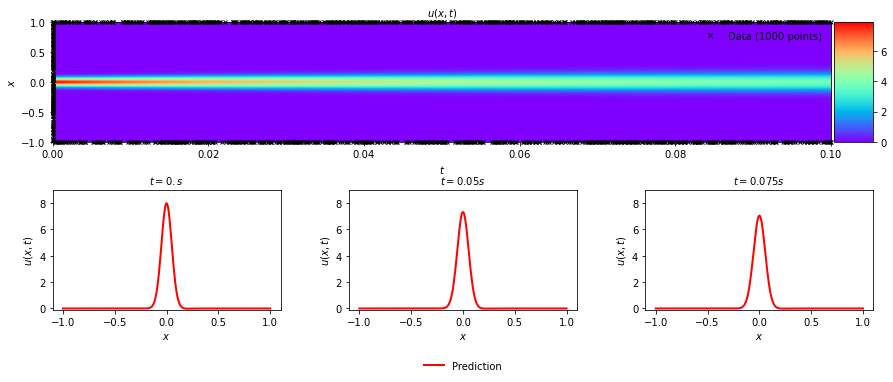

In [140]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)

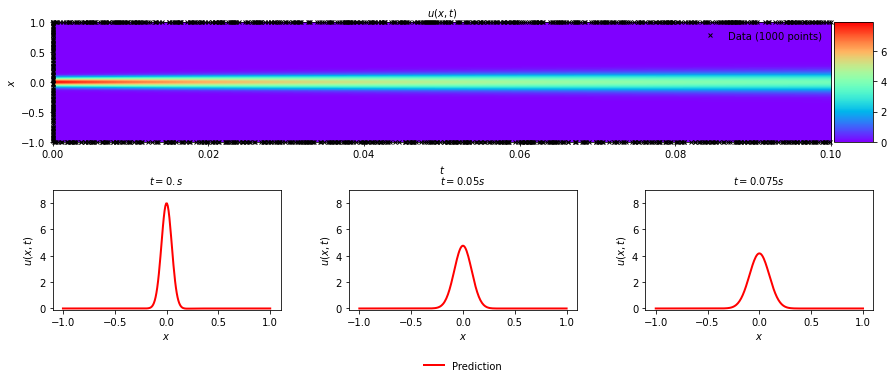

In [147]:
solutionplot(u_pred,X_u_train,u_train)

In [145]:
u_pred.shape

(256, 1000)

# Plot of collocation points

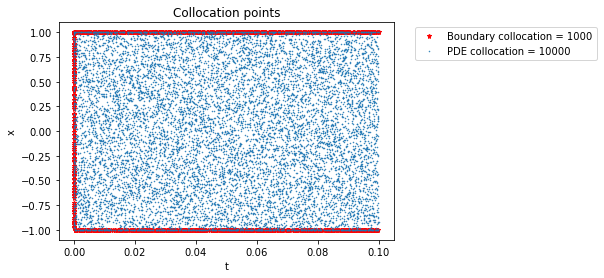

In [142]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [143]:

x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

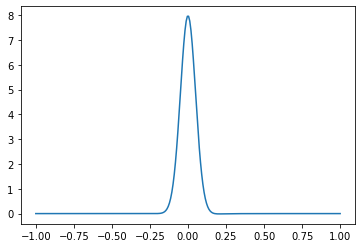

In [144]:
plt.plot(x, u_pred[:,1])


In [148]:
import ipywidgets

def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, 0.099, 0.007))

interactive(children=(FloatSlider(value=0.049, description='time', max=0.099, step=0.007), Output()), _dom_cla…

<function __main__.inter_pred(time)>